## Assignment 4

Import Important Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import dataset as pdata

In [2]:
pdata=pd.read_csv("/time_series_ass3.csv")

Understanding the data

In [3]:
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          8640 non-null   int64  
 1   From                8640 non-null   object 
 2   To (Interval: 15M)  8640 non-null   object 
 3   PM10 (µg/m3)        6959 non-null   float64
 4   PM2.5 (µg/m3)       8414 non-null   float64
 5   NO (µg/m3)          7271 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 405.1+ KB


In [4]:
pdata.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
pdata['From'] = pd.to_datetime(pdata['From'])
pdata.set_index('From', inplace=True)


In [6]:
pdata.head()

,To (Interval: 15M),PM10 (µg/m3),PM2.5 (µg/m3),NO (µg/m3)
From,,,,
2023-02-01 00:00:00,2023-02-01 00:15:00,95.0,35.0,NaN
2023-02-01 00:15:00,2023-02-01 00:30:00,95.0,35.0,NaN
2023-02-01 00:30:00,2023-02-01 00:45:00,95.0,35.0,NaN
2023-02-01 00:45:00,2023-02-01 01:00:00,122.0,34.0,NaN
2023-02-01 01:00:00,2023-02-01 01:15:00,122.0,34.0,NaN


In [7]:
pdata.tail()

,To (Interval: 15M),PM10 (µg/m3),PM2.5 (µg/m3),NO (µg/m3)
From,,,,
2023-05-01 22:45:00,2023-05-01 23:00:00,19.0,11.0,17.9
2023-05-01 23:00:00,2023-05-01 23:15:00,19.0,11.0,17.9
2023-05-01 23:15:00,2023-05-01 23:30:00,19.0,11.0,19.6
2023-05-01 23:30:00,2023-05-01 23:45:00,19.0,11.0,20.8
2023-05-01 23:45:00,2023-05-02 00:00:00,32.0,6.0,21.8


<Axes: ylabel='From'>

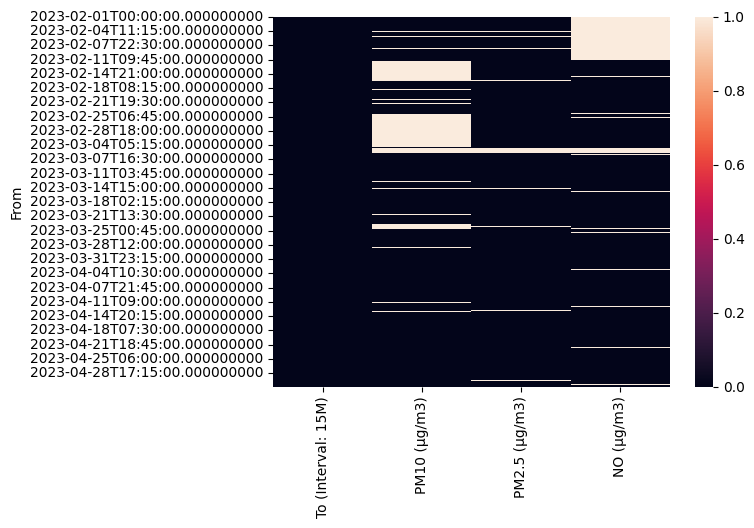

In [8]:
sns.heatmap(pdata.isnull())

**Preparing the Data**

Handling Outliers

In [9]:
from datetime import datetime
ed=datetime(2023,2,28,0,0,0)

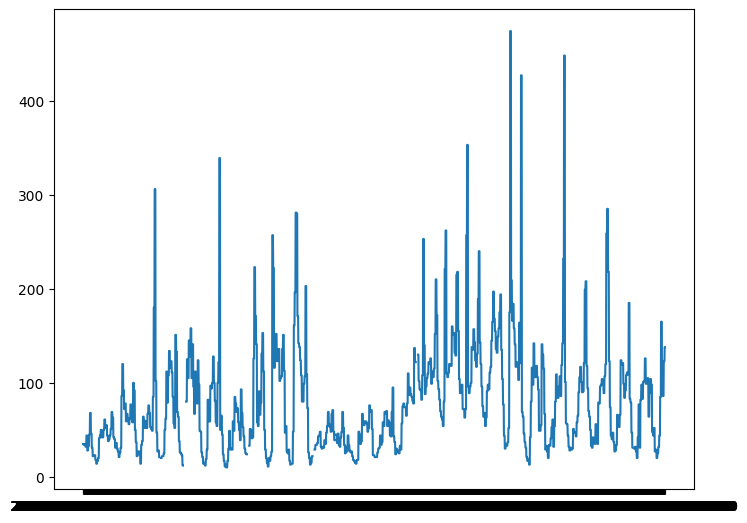

In [10]:
fi = plt.figure()
axes = fi.add_axes([0,0,1,1])
plt.plot(pdata['To (Interval: 15M)'][:ed],pdata['PM2.5 (µg/m3)'][:ed])

In [15]:
def outl(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = np.where((data < lower_bound) | (data > upper_bound), np.nan, data)
    return data

In [16]:
pdata['NO (µg/m3)']=outl(pdata['NO (µg/m3)'])
pdata['PM10 (µg/m3)']=outl(pdata['PM10 (µg/m3)'])
pdata['PM2.5 (µg/m3)']=outl(pdata['PM2.5 (µg/m3)'])

In [17]:
pdata['NO (µg/m3)']=pdata['NO (µg/m3)'].interpolate(method='linear')
pdata['PM10 (µg/m3)']=pdata['PM10 (µg/m3)'].interpolate(method='linear')
pdata['PM2.5 (µg/m3)']=pdata['PM2.5 (µg/m3)'].interpolate(method='linear')

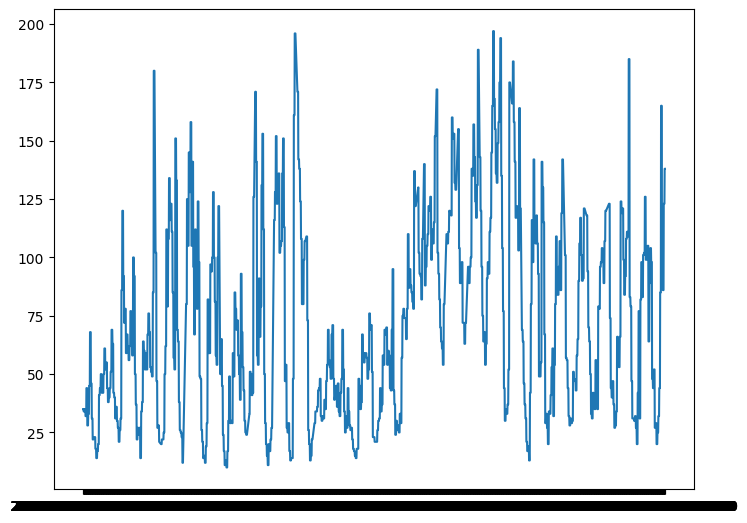

In [18]:
fi1 = plt.figure()
axes = fi1.add_axes([0,0,1,1])
plt.plot(pdata['To (Interval: 15M)'][:ed],pdata['PM2.5 (µg/m3)'][:ed])

Predicting the missing values using ARIMA

In [19]:
from statsmodels.tsa.stattools import adfuller
adr=adfuller(pdata['PM10 (µg/m3)'][6000:],autolag='AIC')
print(adr)
if(adr[1]<0.05):
  print("data can be considered stationary")

(-6.021708098995731, 1.4883623096497245e-07, 16, 2623, {'1%': -3.432845505561489, '5%': -2.8626425238284, '10%': -2.5673569122802786}, 24418.82981459542)
data can be considered stationary


Since p-value is very small 2.9e-8, we can say the data is not seasonal.

In [20]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00


In [21]:
from pmdarima import auto_arima
model = auto_arima(pdata['PM10 (µg/m3)'])

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8640
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -39338.165
Date:                Thu, 13 Jul 2023   AIC                          78690.331
Time:                        17:18:05   BIC                          78739.779
Sample:                    02-01-2023   HQIC                         78707.191
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9237      0.034    -27.478      0.000      -0.990      -0.858
ar.L2         -0.8561      0.037    -23.171      0.000      -0.929      -0.784
ar.L3         -0.8034      0.011    -75.321      0.000      -0.824      -0.782
ma.L1          0.9586      0.022     44.581      0.000       0.916       1.001
ma.L2          0.9226      0.023     39.743      0.000       0.877       0.968
ma.L3          0.9001      0.009    102.403      0.000       0.883       0.917
sigma2       526.4746      1.981    265.706      0.000     522.591     530.358
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            444466.04
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
from statsmodels.tsa.arima.model import ARIMA

In [54]:
def prdict(data):
  train_size = int(len(data) * 0.8)  # 80% for training
  train_data, test_data = data[:train_size], data[train_size:]
  order = (17,1,0)  # Specify the order of the ARIMA model
  model = ARIMA(train_data, order=order)
  fitted_model = model.fit()
  # Make predictions
  predictions = fitted_model.predict(start=len(train_data), end=len(data)-1)
  return predictions


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


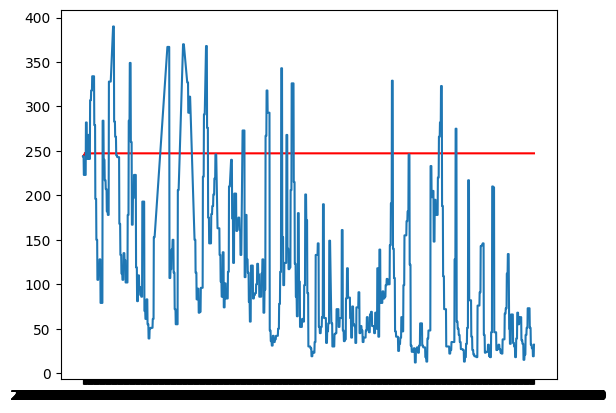

In [55]:
predpm10=prdict(pdata['PM10 (µg/m3)'])
plt.plot(pdata['To (Interval: 15M)'][train_size:], predpm10,'r')
plt.plot(pdata['To (Interval: 15M)'][train_size:], pdata['PM10 (µg/m3)'][train_size:])

In [64]:
def next_10(data):
    ar=ARIMA(data,order=(3,1,3))
    ar_fit=ar.fit()
    forecast=ar_fit.forecast(steps=960)
    return forecast
pm10=next_10(pdata['PM10 (µg/m3)'])
pm25=next_10(pdata['PM2.5 (µg/m3)'])
no=next_10(pdata['NO (µg/m3)'])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be 

In [66]:

last_date = datetime(2023,5,2,0,0,0)
dates = pd.date_range(start=last_date + pd.Timedelta(minutes=15), periods=960, freq='15Min')
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

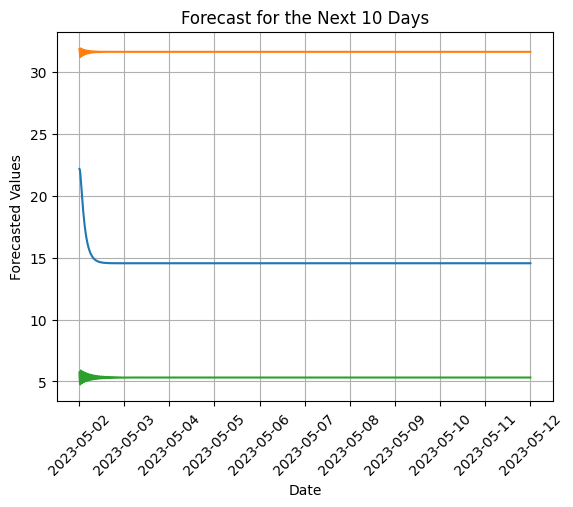

In [67]:
axes = fig.add_axes([0,0,1,1])
plt.plot(dates,no,'r')
plt.plot(dates,pm10,'b')
plt.plot(dates,pm25)
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.title('Forecast for the Next 10 Days')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

RNN

In [70]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_no = scaler.fit_transform(pdata['NO (µg/m3)'].values.reshape(-1, 1))
scaled_pm10 = scaler.fit_transform(pdata['PM10 (µg/m3)'].values.reshape(-1, 1))
scaled_pm25 = scaler.fit_transform(pdata['PM2.5 (µg/m3)'].values.reshape(-1, 1))


In [72]:
train_size = int(len(scaled_pm10) * 0.8)  # 80% for training
train_data = scaled_pm10[:train_size]
test_data = scaled_pm10[train_size:]

In [74]:
def reshape_data(data):
    return np.reshape(data, (data.shape[0], 1, data.shape[1]))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(reshape_data(train_data), train_data, epochs=75, batch_size=1, verbose=2)


Epoch 1/75
6912/6912 - 29s - loss: 0.0013 - 29s/epoch - 4ms/step
Epoch 2/75
6912/6912 - 34s - loss: 2.1437e-05 - 34s/epoch - 5ms/step
Epoch 3/75
6912/6912 - 20s - loss: 1.5940e-05 - 20s/epoch - 3ms/step
Epoch 4/75
6912/6912 - 19s - loss: 1.6492e-05 - 19s/epoch - 3ms/step
Epoch 5/75
6912/6912 - 19s - loss: 1.4905e-05 - 19s/epoch - 3ms/step
Epoch 6/75
6912/6912 - 19s - loss: 1.6640e-05 - 19s/epoch - 3ms/step
Epoch 7/75
6912/6912 - 19s - loss: 1.4159e-05 - 19s/epoch - 3ms/step
Epoch 8/75
6912/6912 - 20s - loss: 1.1707e-05 - 20s/epoch - 3ms/step
Epoch 9/75
6912/6912 - 18s - loss: 1.0783e-05 - 18s/epoch - 3ms/step
Epoch 10/75
6912/6912 - 19s - loss: 1.6246e-05 - 19s/epoch - 3ms/step
Epoch 11/75
6912/6912 - 31s - loss: 1.0144e-05 - 31s/epoch - 4ms/step
Epoch 12/75
6912/6912 - 22s - loss: 1.1816e-05 - 22s/epoch - 3ms/step
Epoch 13/75
6912/6912 - 20s - loss: 8.4186e-06 - 20s/epoch - 3ms/step
Epoch 14/75
6912/6912 - 20s - loss: 1.1059e-05 - 20s/epoch - 3ms/step
Epoch 15/75
6912/6912 - 21s - los

In [75]:
train_predictions = model.predict(reshape_data(train_data))
test_predictions = model.predict(reshape_data(test_data))


54/54 [==============================] - 0s 3ms/step


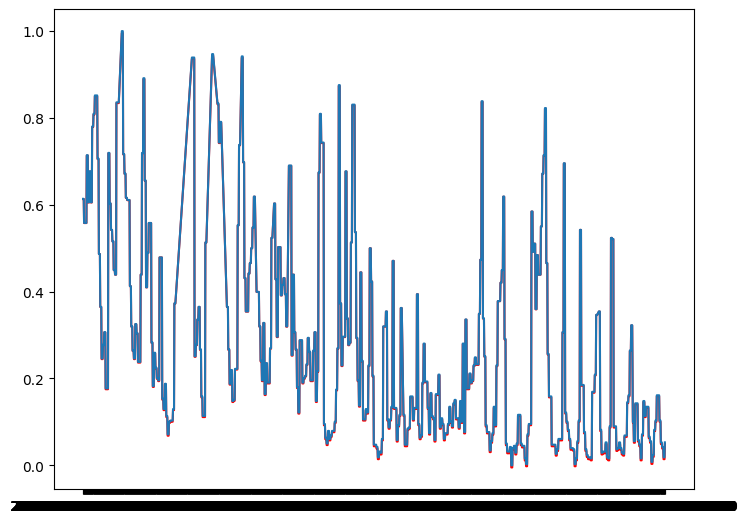

In [76]:
fig1 = plt.figure()
axes = fig1.add_axes([0,0,1,1])
plt.plot(pdata['To (Interval: 15M)'][train_size:], test_predictions,'r')
plt.plot(pdata['To (Interval: 15M)'][train_size:], test_data)
#
plt.show()

In [77]:
input_window = train_data[-1:]  # Use the last window from training data

# Define the forecast horizon
forecast_horizon = 960

# Generate forecasts
forecasts = []
for _ in range(forecast_horizon):
    input_window_reshaped = np.reshape(input_window, (1, 1, 1))
    forecast = model.predict(input_window_reshaped)
    forecasts.append(forecast[0, 0])  # Assuming the forecast is a single value
    input_window = np.append(input_window[1:], forecast)

# Convert forecasts to the original scale if necessary
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))


1/1 [==============================] - 0s 25ms/step


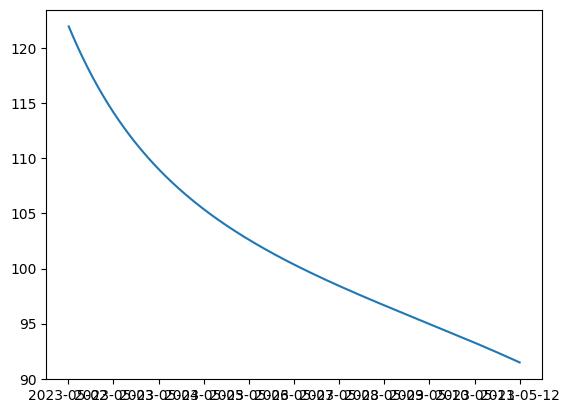

In [78]:
plt.plot(dates,forecasts)
plt.show()